# Cell browser.

In [1]:
%matplotlib widget

In [2]:

import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RangeSlider
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from tifffile import imread as tiff_imread

# ────────────────────────────────────────────────────────────────────────
# CONFIGURATION — update as needed
# ────────────────────────────────────────────────────────────────────────
IMAGE_DIR = r"D:\Confocal_imaging_nuclei_tif\MIST_Fused_Images\ROIs"

PX_PER_UM = 8.0453         # pixels per micrometer
SCALER_LENGTH_UM = 1.0     # scalebar length in micrometers
N_SAMPLES = 1_000         # random sample size
RANDOM_SEED = None         # set to an int for reproducibility

print("IMAGE_DIR =", IMAGE_DIR)
print("Target sample size =", N_SAMPLES)


IMAGE_DIR = D:\Confocal_imaging_nuclei_tif\MIST_Fused_Images\ROIs
Target sample size = 1000


In [3]:

def iter_tiff_paths(root):
    tif_exts = ('.tif', '.tiff')
    for dirpath, dirnames, filenames in os.walk(root):
        for fn in filenames:
            if fn.lower().endswith(tif_exts):
                yield os.path.join(dirpath, fn)

def sample_random_paths(root, k, seed=None, progress_every=100_000):
    rng = np.random.default_rng(seed)
    reservoir, n_seen = [], 0
    t0 = time.time()
    for p in iter_tiff_paths(root):
        n_seen += 1
        if len(reservoir) < k:
            reservoir.append(p)
        else:
            j = rng.integers(0, n_seen)
            if j < k:
                reservoir[j] = p
        if progress_every and (n_seen % progress_every == 0):
            print(f"[scan] seen={n_seen:,} files ... ({time.time()-t0:.1f}s)")
    print(f"[done] scanned {n_seen:,} TIFF files total.")
    if not reservoir:
        raise RuntimeError(f"No TIFFs found in {root}")
    print(f"[done] sampled {len(reservoir):,} files.")
    return reservoir

def load_gray(path):
    img = tiff_imread(path)
    if img.ndim == 3:
        img = img[..., 0]
    return img

paths = sample_random_paths(IMAGE_DIR, N_SAMPLES, seed=RANDOM_SEED)
n = len(paths)
print(f"Sample size: n = {n}")


[scan] seen=100,000 files ... (1.0s)
[scan] seen=200,000 files ... (1.3s)
[scan] seen=300,000 files ... (1.5s)
[scan] seen=400,000 files ... (1.7s)
[scan] seen=500,000 files ... (2.0s)
[scan] seen=600,000 files ... (2.2s)
[scan] seen=700,000 files ... (2.4s)
[scan] seen=800,000 files ... (2.7s)
[scan] seen=900,000 files ... (2.9s)
[scan] seen=1,000,000 files ... (3.2s)
[done] scanned 1,061,277 TIFF files total.
[done] sampled 1,000 files.
Sample size: n = 1000


0

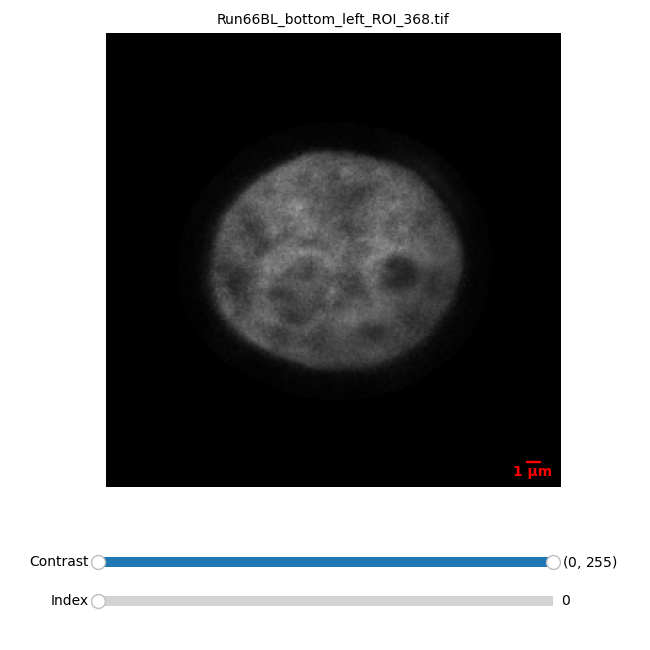

In [4]:
#| label: cell_browser

# Initial figure
img0 = load_gray(paths[0])

if np.issubdtype(img0.dtype, np.integer):
    lo0, hi0 = 0, int(np.iinfo(img0.dtype).max)
else:
    lo0, hi0 = float(np.nanmin(img0)), float(np.nanmax(img0))

fig, ax = plt.subplots(figsize=(6.5, 6.5))
plt.subplots_adjust(bottom=0.25, top=0.95)
im = ax.imshow(img0, cmap='gray', vmin=lo0, vmax=hi0)
ax.set_axis_off()
title = ax.set_title(os.path.basename(paths[0]), fontsize=10)

# Scalebar
bar_px = SCALER_LENGTH_UM * PX_PER_UM
fontprops = fm.FontProperties(size=10, weight='bold')
scalebar = AnchoredSizeBar(ax.transData, bar_px, f"{SCALER_LENGTH_UM:g} μm",
                           loc='lower right', pad=0.5, color='red',
                           frameon=False, size_vertical=1, fontproperties=fontprops)
ax.add_artist(scalebar)

# Contrast slider
contrast_ax = fig.add_axes([0.15, 0.12, 0.70, 0.03])
step = max(1, (hi0 - lo0) // 1024) if np.issubdtype(img0.dtype, np.integer) else 0.0
contrast_slider = RangeSlider(ax=contrast_ax, label='Contrast',
                              valmin=lo0, valmax=hi0, valinit=(lo0, hi0),
                              valstep=step if step > 0 else None)

def update_contrast(_):
    lo, hi = contrast_slider.val
    im.set_clim(lo, hi)
    fig.canvas.draw_idle()

contrast_slider.on_changed(update_contrast)

# Index slider — renamed label
idx_ax = fig.add_axes([0.15, 0.06, 0.70, 0.03])
idx_slider = Slider(ax=idx_ax, label='Index',
                    valmin=0, valmax=n-1, valinit=0, valstep=1, valfmt='%0.0f')

def update_image(_):
    idx = int(idx_slider.val)
    try:
        new_img = load_gray(paths[idx])
    except Exception as e:
        print(f"[warn] failed to read {paths[idx]} → {e}")
        return
    im.set_data(new_img)
    # preserve current contrast
    lo, hi = contrast_slider.val
    im.set_clim(lo, hi)
    title.set_text(os.path.basename(paths[idx]))
    fig.canvas.draw_idle()

idx_slider.on_changed(update_image)

# DO NOT return `fig` here, to avoid duplicate static rendering.
# The ipympl backend will display the interactive figure automatically.


In [5]:

# Make Matplotlib toolbar Back/Forward act as prev/next index
tb = getattr(fig.canvas, "toolbar", None)
if tb is None:
    print("No toolbar found (backend may not expose it).")
else:
    try:
        _orig_back = getattr(tb, "back", None)
        _orig_forward = getattr(tb, "forward", None)
    except Exception:
        _orig_back = _orig_forward = None

    def _back_override(*args, **kwargs):
        cur = int(idx_slider.val)
        if cur > 0:
            idx_slider.set_val(cur - 1)

    def _forward_override(*args, **kwargs):
        cur = int(idx_slider.val)
        if cur < n - 1:
            idx_slider.set_val(cur + 1)

    # Override handlers used by toolbar buttons
    try:
        tb.back = _back_override
        tb.forward = _forward_override
        print("Toolbar back/forward now move index ↑/↓.")
    except Exception as e:
        print(f"Could not override toolbar: {e}")


Toolbar back/forward now move index ↑/↓.
